# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [7]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [2]:
import string 
class Vocab:
    def __init__(self, data, max_len = 150):
        self.max_len = max_len

        self.char2idx = dict()
        self.idx2char = dict()

        cnt_all = 0

        self.char2idx['<START>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<START>'
        cnt_all += 1

        self.char2idx['<END>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<END>'
        cnt_all += 1

        self.char2idx['<PAD>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<PAD>'
        cnt_all += 1

        self.char2idx['<UNK>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<UNK>'
        cnt_all += 1
        

        for symb in data:
             if symb not in self.char2idx.keys():
                self.char2idx[symb] = cnt_all + 1
                self.idx2char[cnt_all + 1] = symb
                cnt_all += 1          

    def tokenize(self, sequence):
        converted_sentence = ''
        for symb in sequence:
            if symb in string.ascii_letters or symb in string.punctuation or symb == ' ':
                converted_sentence += symb
        return [1] + [self.char2idx.get(char, 4) for char in converted_sentence] + [2]
    
    def detokenize(self, sequence):
        if len(sequence) <= self.max_len:
            return ''.join([self.idx2char.get(idx, '<UNK>') for idx in sequence])
        else:
            return ''.join([self.idx2char.get(idx, '<UNK>') for idx in sequence[:self.max_len]]) + '<PAD>'
    
    def __len__(self):
        return len(self.char2idx)

In [3]:
class TextDataset():
    
    def __init__(self, data_path, symb_in_sentence = 100):
        # загрузите данные
        f = open(data_path)
        data = ''
        for line in f:
            data += line

        # обучите вокаб
        self.vocab = Vocab(data)
        array_data = self.vocab.tokenize(data)
        # разделите данные на отдельные сэмплы для обучения
        # (просто список из сырых строк)
        self.data = []
        for i in range(len(array_data) // symb_in_sentence):
            self.data.append(array_data[(i * symb_in_sentence) : ((i + 1) * symb_in_sentence)])
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        #sample = self.vocab.tokenize(sample)
        #sample = sam# паддинг до maxlen (см. дальше)
        sample = torch.LongTensor(sample) # сконвертируйте в LongTensor
        #target = sample[1:]# нужно предсказать эту же последовательность со сдвигом 1
        return sample

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

In [8]:
def getlen(path):
    fil = open(path)
    s = ""
    for line in fil:
        s += line
    return len(s)

getlen('tran.txt')

759106

In [10]:
dataset = TextDataset('/content/tran.txt')


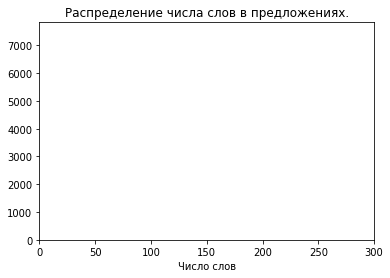

In [11]:
plt.hist([len(x) for x in dataset], bins=350)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
plt.xlim((0, 300))
plt.show()

Разобьём на обучение и валидацию:

In [12]:

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [34]:
class LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, tie_weights):
        super().__init__()
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, bidirectional = True)
        self.decoder = nn.Linear(hidden_dim * 2, vocab_size)
        self.drop = nn.Dropout(dropout)
        
        if tie_weights:
            # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
            # https://arxiv.org/abs/1608.05859
            assert 2 * hidden_dim == embedding_dim
            self.decoder.weight = self.encoder.weight
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        #self.rnn_type = rnn_type
        #self.nhid = nhid
        #self.nlayers = nlayers

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, shape):
        # начальный хидден должен быть нулевой
        # (либо хоть какой-то константный для всего обучения)
        return torch.zeros(shape).to(device)

## Обучение

In [15]:
epochs = 12
lr = 1e-3 
batch_size = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LM(
    vocab_size = len(dataset.vocab) + 1,
    embedding_dim = 256,
    hidden_dim = 128,
    num_layers = 20,
    dropout = 0.1,
    tie_weights= True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train = DataLoader(train_set, batch_size=batch_size)
test = DataLoader(test_set, batch_size=batch_size)

In [16]:
from tqdm.auto import tqdm

losses_train = []
losses_test = []
for e in tqdm(range(epochs)):
    sum_train = 0
    cnt_train = 0
    for batch in tqdm(train):
        model.train()
        x = batch.to(device)
        y = batch[:, 1:].to(device)
        optimizer.zero_grad()
        
        hidden = model.init_hidden((model.num_layers * 2, x.shape[1], model.hidden_dim))
        output, hidden = model(x, hidden)
        target = torch.zeros(y.shape[0], y.shape[1], len(dataset.vocab) + 1).to(device)
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                target[i][j][y[i][j]] = 1.0

        loss = criterion(output[:, :output.shape[1] - 1, :], target)
        sum_train += loss.item()
        cnt_train += output.shape[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        losses_train.append(loss.item())
        optimizer.step()
    
    sum_test = 0
    cnt_test = 0

    for batch in test:
        model.eval()
        x = batch.to(device)
        y = batch[:, 1:].to(device)
        target = torch.zeros(y.shape[0], y.shape[1], len(dataset.vocab) + 1).to(device)
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                target[i][j][y[i][j]] = 1.0

        output, hidden = model(x, hidden)
        loss = criterion(output[:, :output.shape[1] - 1, :], target)
        sum_test += loss.item()
        cnt_test += output.shape[0]
        losses_test.append(loss.item())
    print(f'Mean train loss in epoch {e} is {sum_train / cnt_train} | test loss is {sum_test / cnt_test}')

        # сдесь нужно сделать то же самое, только без backward

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 0 is 0.5393906494799156 | test loss is 0.508974125813543


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 1 is 0.505338465947087 | test loss is 0.5016928045104081


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 2 is 0.5003531538594246 | test loss is 0.4985884539882875


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 3 is 0.49775910299309106 | test loss is 0.4966294024009807


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 4 is 0.495947607230344 | test loss is 0.4956189831843645


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 5 is 0.49480928604135077 | test loss is 0.4963629642057035


  0%|          | 0/671 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Loss on train')

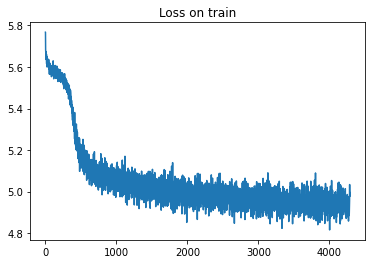

In [17]:
plt.plot(losses_train)
plt.title("Loss on train")

Text(0.5, 1.0, 'Loss on test')

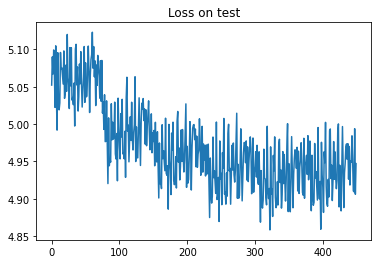

In [18]:
plt.plot(losses_test)
plt.title("Loss on test")

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [19]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Pour me an expresso'.split(), [0, 0, 100], ' ')

sequence = 'This homework must be completed within two weeks'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [20]:
def spellcheck(sequence):
    model.eval()
    
    # векторизуйте sequence; паддинги делать не нужно
    sequence_vec = torch.LongTensor(dataset.vocab.tokenize(sequence)).reshape(1, -1).to(device)
    
    # прогоните модель и посчитайте лосс, но не усредняйте
    # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
    hidden =  model.init_hidden((model.num_layers * 2, sequence_vec.shape[1], model.hidden_dim))
    losses, _ = model(sequence_vec, hidden)
    losses = losses * 100
    print_colored(sequence, losses.reshape(-1).cpu().detach().numpy())

In [21]:
sequences = ['there are a lot of typos in this sentence', 
             'An extra letter appeared here.', 
             'Everything is fine in this sentence.', 
             'Isanything written with a hyphen.']

for sequence in sequences:
    spellcheck(sequence)

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [22]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
    input = torch.LongTensor(dataset.vocab.tokenize(seed)).reshape(1, -1).to(device)

    hidden = model.init_hidden((model.num_layers * 2, input.shape[1], model.hidden_dim))
    # векторизауйте seed, чтобы на первом этап получить нужный hidden    
    
    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = output.squeeze().div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]
        
        continuation += dataset.vocab.idx2char[token.item()]# допишите соответствующий символ
        input = torch.LongTensor(dataset.vocab.tokenize(seed + continuation)).reshape(1, -1).to(device) # обновите input
        hidden = model.init_hidden((model.num_layers * 2, input.shape[1], model.hidden_dim))

    return continuation

In [23]:
beginnings = ['A bear was walking through the forest',
'An Englishman, an American and a Russian met. The Englishman says:',
'So, one day the jocks decided to do repairs',
'Lieutenant Rzhevsky was',
'Buddha and his disciples are walking along the road',
'Muller: Stirlitz, where were you in 1938?',
'The Americans are sending us a spy disguised as a student',
'The train is approaching Dolgopa:']

for beginning in beginnings:
    print(f'{beginning}... {sample(10, beginning)}')
    print()

A bear was walking through the forest... G6("MGFGCL

An Englishman, an American and a Russian met. The Englishman says:... qCFG<START>MVMjF

So, one day the jocks decided to do repairs... BJGkWCHSF<END>

Lieutenant Rzhevsky was... bC"RW8KpMK

Buddha and his disciples are walking along the road... CPFPJEFVGn

Muller: Stirlitz, where were you in 1938?... h<END>HOT?MJGt

The Americans are sending us a spy disguised as a student... *BD"hCJVDR

The train is approaching Dolgopa:... AhKbCps<START>gK



Сделаем более продвинутую модель на word-level, а то на char-level какая-то чушь:

Опять же, попробуем сделать класс Vocab, только для слов:

In [1]:
class VocabWord:
    def __init__(self, data, max_len = 100):
        self.max_len = max_len
        self.text = self.clean_text(data)
        
        self.char2idx = dict()
        self.idx2char = dict()

        cnt_all = 0

        self.char2idx['<START>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<START>'
        cnt_all += 1

        self.char2idx['<END>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<END>'
        cnt_all += 1

        self.char2idx['<PAD>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<PAD>'
        cnt_all += 1

        self.char2idx['<UNK>'] = cnt_all + 1
        self.idx2char[cnt_all + 1] = '<UNK>'
        cnt_all += 1 

        for symb in self.text.split():
             if symb not in self.char2idx.keys():
                self.char2idx[symb] = cnt_all + 1
                self.idx2char[cnt_all + 1] = symb
                cnt_all += 1    

    def tokenize(self, sequence):
        converted_sentence = ''
        for symb in sequence:
            if symb in string.ascii_letters or symb in string.punctuation or symb == ' ':
                converted_sentence += symb
        return [1] + [self.char2idx.get(char, 4) for char in converted_sentence] + [2]
    
    def detokenize(self, sequence):
        if len(sequence) <= self.max_len:
            return ''.join([self.idx2char.get(idx, '<UNK>') for idx in sequence])
        else:
            return ''.join([self.idx2char.get(idx, '<UNK>') for idx in sequence[:self.max_len]]) + '<PAD>'
    
    def __len__(self):
        return len(self.char2idx)

    def clean_text(self, data):
        answer = ""
        prev = ' '
        for symb in data:
            if symb in string.ascii_letters:
                answer += symb
                prev = symb
            elif prev != symb:
                answer += ' '
        return answer


In [4]:
import string
class TextDatasetWord():
    def __init__(self, data_path, symb_in_sentence = 100):
        f = open(data_path)
        data = ''
        for line in f:
            data += line

        self.vocab = VocabWord(data)
        array_data = self.vocab.tokenize(data)
        self.data = []
        for i in range(len(array_data) // symb_in_sentence):
            self.data.append(array_data[(i * symb_in_sentence) : ((i + 1) * symb_in_sentence)])
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.LongTensor(sample)
        return sample

In [5]:
dataset = TextDatasetWord('/content/tran.txt')


In [8]:

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [35]:
epochs = 12
lr = 1e-3 
batch_size = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LM(
    vocab_size = len(dataset.vocab) + 1,
    embedding_dim = 256,
    hidden_dim = 128,
    num_layers = 20,
    dropout = 0.1,
    tie_weights= True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train = DataLoader(train_set, batch_size=batch_size)
test = DataLoader(test_set, batch_size=batch_size)

In [40]:
from tqdm.auto import tqdm

losses_train = []
losses_test = []
for e in tqdm(range(epochs)):
    sum_train = 0
    cnt_train = 0
    for batch in tqdm(train):
        model.train()
        x = batch.to(device)
        y = batch[:, 1:].to(device)
        optimizer.zero_grad()
        
        hidden = model.init_hidden((model.num_layers * 2, x.shape[1], model.hidden_dim))
        output, hidden = model(x, hidden)
        target = torch.zeros(y.shape[0], y.shape[1], len(dataset.vocab) + 1).to(device)
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                target[i][j][y[i][j]] = 1.0

        loss = criterion(output[:, :output.shape[1] - 1, :], target)
        sum_train += loss.item()
        cnt_train += output.shape[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        losses_train.append(loss.item())
        optimizer.step()
    
    sum_test = 0
    cnt_test = 0

    for batch in test:
        model.eval()
        x = batch.to(device)
        y = batch[:, 1:].to(device)
        target = torch.zeros(y.shape[0], y.shape[1], len(dataset.vocab) + 1).to(device)
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                target[i][j][y[i][j]] = 1.0

        output, hidden = model(x, hidden)
        loss = criterion(output[:, :output.shape[1] - 1, :], target)
        sum_test += loss.item()
        cnt_test += output.shape[0]
        losses_test.append(loss.item())
    print(f'Mean train loss in epoch {e} is {sum_train / cnt_train} | test loss is {sum_test / cnt_test}')


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 0 is 0.00477641186031047 | test loss is 0.004759140517412817


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 1 is 0.004692569758785254 | test loss is 0.004682074243517408


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 2 is 0.004658627801962956 | test loss is 0.00467076857671661


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 3 is 0.0046476962924510085 | test loss is 0.004661598694747958


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 4 is 0.004642216766394173 | test loss is 0.004663104540980533


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 5 is 0.004638621889579026 | test loss is 0.004656368936474457


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 6 is 0.00463616121260446 | test loss is 0.004657037626083031


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 7 is 0.004633014426346186 | test loss is 0.004650867396800831


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 8 is 0.004630646377926294 | test loss is 0.004653919642995893


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 9 is 0.004628713503724312 | test loss is 0.004649735707539975


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 10 is 0.004626955156707131 | test loss is 0.004653369678289257


  0%|          | 0/671 [00:00<?, ?it/s]

Mean train loss in epoch 11 is 0.004624561320037343 | test loss is 0.004652311466134905


Text(0.5, 1.0, 'Loss on train')

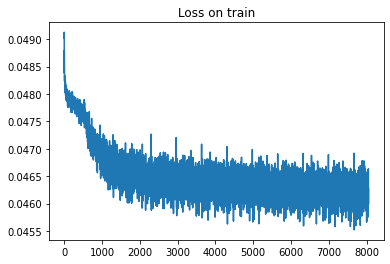

In [41]:
plt.plot(losses_train)
plt.title("Loss on train")

Text(0.5, 1.0, 'Loss on test')

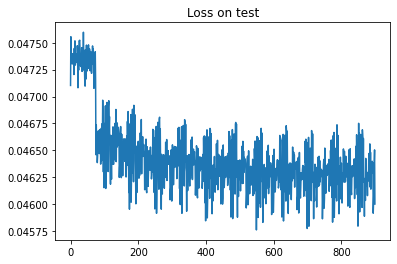

In [42]:
plt.plot(losses_test)
plt.title("Loss on test")

In [45]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
    input = torch.LongTensor(dataset.vocab.tokenize(seed)).reshape(1, -1).to(device)

    hidden = model.init_hidden((model.num_layers * 2, input.shape[1], model.hidden_dim))
    # векторизауйте seed, чтобы на первом этап получить нужный hidden    
    
    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = output.squeeze().div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]
        
        continuation += dataset.vocab.idx2char[token.item()] + ' '# допишите соответствующий символ
        input = torch.LongTensor(dataset.vocab.tokenize(seed + continuation)).reshape(1, -1).to(device) # обновите input
        hidden = model.init_hidden((model.num_layers * 2, input.shape[1], model.hidden_dim))

    return continuation

In [47]:
beginnings = ['Andrew was walking through the forest',
'An Englishman, an American and a Russian met. The Englishman says:',
'So, one day the jocks decided to do repairs',
'Lieutenant Rzhevsky was',
'Buddha and his disciples are walking along the road',
'Muller: Stirlitz, where were you in 1938?',
'The Americans are sending us a spy disguised as a student',
'The train is approaching Dolgopa:']

for beginning in beginnings:
    print(f'{beginning}... {sample(10, beginning)}')
    print()

Andrew was walking through the forest... fetched feminine Such rebuke Guard touches double plaintive Plenty astonished 

An Englishman, an American and a Russian met. The Englishman says:... loots slip fo unclasped wipe approval poor trifle plumage Glancing 

So, one day the jocks decided to do repairs... Women profit duelist Can monstrosity rotary thin companion well squadron 

Lieutenant Rzhevsky was... dear pieces operate Turning middle Amstetten flings fallen ransack depended 

Buddha and his disciples are walking along the road... gare narrating Head prodigal homeless Please patties Kill La reckless 

Muller: Stirlitz, where were you in 1938?... preclude exciting toes bids overcoats accompany seem confluence ancient Life 

The Americans are sending us a spy disguised as a student... Matvevna strenuous weariness mouth dream angle defection outposts tat afloat 

The train is approaching Dolgopa:... portly leaned tenfold superfluous Silence snorted instead current off Formio 

